# Examining the relationship between $\Delta \text{Precip}$ anomalies to $\Delta \text{SST}$ perturbations

Go to section:
- [Imports and utility functions](#imports)
- [Calculating the GTO](#GTO_calc)
- [Examining linearity of relatonship](#linearity)

## Imports and utility functions 
<a id='imports'></a>

In [2]:
import sys, importlib
#importlib.reload(sys.modules['utils']) # makes sure changes in utils.py are updated
from utils import *
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import warnings
mpl.rcParams['text.usetex'] = False  # not really needed
warnings.filterwarnings('ignore') # filter out deprecation warnings for now

In [3]:
cwd = os.getcwd()
cwd

'/gws/nopw/j04/aopp/jessew/stuff_for_jesse'

In [20]:
# Loading in the data
delta_SST = xr.open_dataarray("delta_SST_pr.nc").compute()
delta_precip = xr.open_dataarray("delta_precip.nc").compute()

## Calculating the GTO
<a id='GTO_calc'></a>

As per Baker et al. (2019) and Li et al. (2012), the smoothed GTO estimate at a gridpoint $\mathbf{x}_i$ may be calculated using

$$ G(\mathbf{x}_i) = \frac {\text{Cov}[\Delta \text{SST}_n(\mathbf{x}_i), \mathbf{R}_n]}{\frac{T^2_\text{max}}{3}L_x L_y} + e $$

where $\Delta \text{SST}_n(\mathbf{x}_i)$ is a vector of the 5000 time-independent SST perturbation anomalies at the gridpoint $\mathbf{x}_i$, $\mathbf{R}_n$ a vector of the 5000 atmospheric anomaly indices (in this case the delta_precip vector at the chosen precipitation location), $T_\text{max} = 2\text{K}$ the maximum temperature perturbation, and $L_x = a \lambda_0 \cos{\phi_i}$ and $L_y = a \phi_0$ are the local length scales of the lattice. Here $a$ is the mean earth radius, $\phi_0$ and $\lambda_0$ are the latitude and longitude spacings in radians, and $\phi_i$ the latitude of the grid point in question.

In [22]:
T_max = 2 # maximum temperature perturbation
a = 6371 # earth radius in kilometers
phi_0 = math.radians(1.25) # latitude spacing in radians
lambda_0 = math.radians(1.875) # longitude spacing in radians
lats = delta_SST.lat.values
lons = delta_SST.lon.values

## Visualising the GTO

### Mediterranean

In [119]:
# Select a region of delta precipitation data (vector of 5000 entries)

#mylats = lats[np.logical_and(lats >= 30, lats <= 50)]
#mylons = lons[np.logical_or(lons <= 40, lons >= 350)]
mylat = 35.0
mylon = 225.0

lat_filename = str(mylat).replace(".","")
lon_filename = str(mylon).replace(".","")
    
filename = "GTO_data_10deg/GTO_lat{}_lon{}.nc".format(lat_filename, lon_filename)

In [120]:
G_med = xr.open_dataarray(filename) # select data array of G values

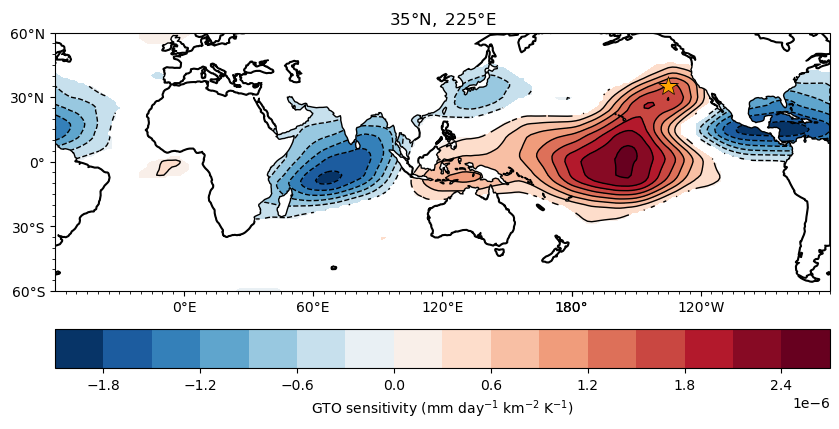

In [125]:
import matplotlib.ticker as tick

fig, ax = visualise_GTO(G_med, lats=lats, lons=lons, central_longitude=120, levels=15,
                       vmax=G_med.max(), vmin=G_med.min())
ax.set_title(r'$ 35\degree \mathrm{N}, \ 225\degree \mathrm{E} $')
ax.plot(mylon, mylat,  markersize=15, marker='*', color='orange', markeredgecolor= "black", markeredgewidth=0.5, zorder=100, transform=ccrs.PlateCarree())
plt.savefig('GTO_Lat35_Lon225.pdf')

### Hong Kong

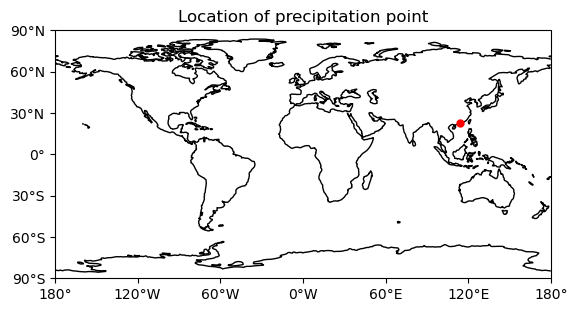

In [49]:
# Hong Kong coordinates: 22.3193° N, 114.1694° E
# Nearest grid point is lat=22.5, lon=114.375
delta_precip_HK = point_delta_precip_vector(mylat=22.5, mylon=114.375)
visualise_point(mylat=22.5, mylon=114.375)

In [12]:
G_HK = xr.open_dataset("GTO_lat100_lon1875.nc")['__xarray_dataarray_variable__'] # select data array of G val

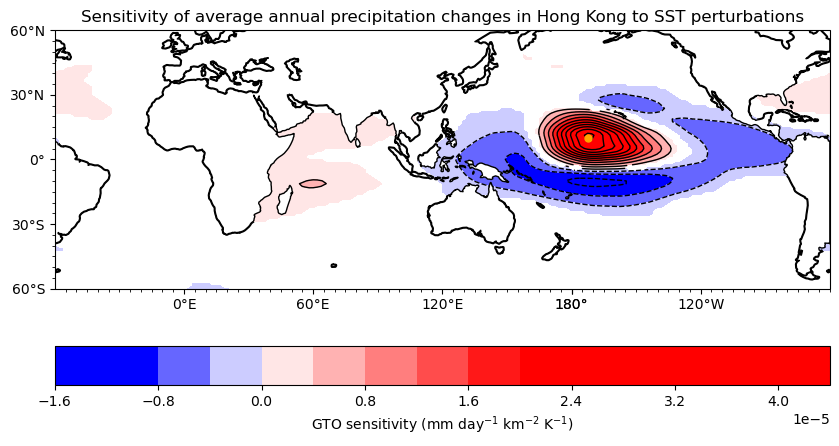

In [14]:
fig, ax = visualise_GTO(G_HK, lats=lats, lons=lons, central_longitude=120, levels=15, vmax=2e-5, vmin=-1e-5)
plt.title('Sensitivity of average annual precipitation changes in Hong Kong to SST perturbations')

ax.plot(187.5, 10,  markersize=5, marker='o', color='orange', zorder=100,transform=ccrs.PlateCarree())
plt.show()

## Examining linearity of relationship
<a id='linearity'></a>

We first create a useful function to help us plot correlations between a given SST gridpoint and a given precipitation gridpoint. Note that we are plotting delta_SST against a weighted version of delta_precip by cos(latitude), to take into account the gridsize differences.

In [5]:
def plot_correlation(delta_precip, delta_SST, sst_latitude, sst_longitude, 
                     precip_latitude, precip_longitude,
                    central_longitude=180):
    '''
    Inputs:
    delta_precip (xarray dataarray)
    sst_latitude(float)
    sst_longitude(float)
    precip_latitude(float)
    precip_longitude(float)
    central_longitude(float, optional) - defaults to 180
    '''
    fig, ax = plt.subplots(1, 1)
    ax.scatter(delta_SST.sel(lat=sst_latitude, lon=sst_longitude).values, 
               point_delta_precip_vector(delta_precip, mylat=precip_latitude, mylon=precip_longitude, time_avg='ANNUAL'), 
               s=1, 
               zorder=100)
    ax.set_xlabel(r'$\Delta \mathrm{SST}$ (K)')
    ax.set_xlim([-2, 2])
    ax.set_ylabel(r'$\Delta \mathrm{P}$ ($\mathrm{mm} \ \mathrm{day}^{-1}$)')
    ax.axvline(x = 0, color = 'grey', label = 'y-axis', ls=':')
    ax.axhline(y = 0, color = 'grey', label = 'x-axis', ls=':')
    ax.set_axisbelow(True)

    #ax.grid()
    ax2 = fig.add_axes([0.69, 0.7, 0.2, 0.2], projection=ccrs.Mollweide(central_longitude=central_longitude))
    ax2.plot(sst_longitude, sst_latitude,  markersize=5, marker='x', color='red', 
             transform=ccrs.PlateCarree(), label=r'$\Delta \mathrm{{SST}}$ grid point')
    #ax2.plot(precip_longitude, precip_latitude,  markersize=5, marker='x', color='green', transform=ccrs.PlateCarree(), label=r'$\Delta \mathrm{{P}}$ grid point')
    #ax2.legend(bbox_to_anchor=(-1.2, 0.95), loc='upper left', borderaxespad=0, handlelength=0)
    ax2.set_global()
    ax2.coastlines()
    return fig, ax, ax2


In [8]:
pacific_lons = [187.5  , 189.375, 191.25 , 193.125, 195.   ,
       196.875, 198.75 , 200.625, 202.5  , 204.375, 206.25 , 208.125,
       210.   , 211.875, 213.75 , 215.625, 217.5  , 219.375, 221.25 ,
       223.125, 225.   , 226.875, 228.75 , 230.625, 232.5  , 234.375,
       236.25 , 238.125, 240.   , 241.875, 243.75 , 245.625, 247.5  ,
       249.375, 251.25 , 253.125, 255.   , 256.875, 258.75 , 260.625,
       262.5]

### Local behaviour

Let us first examine local delta_SST and delta_precip relationships.

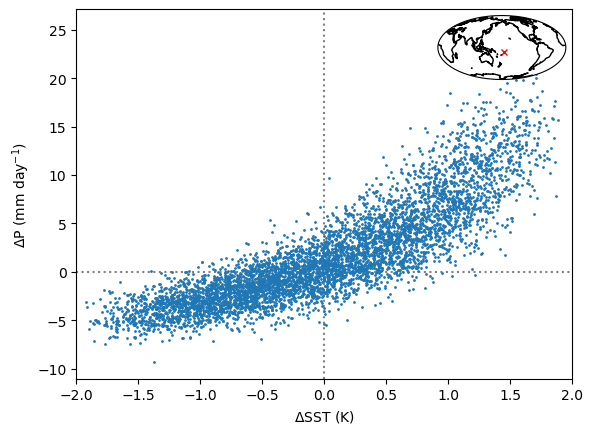

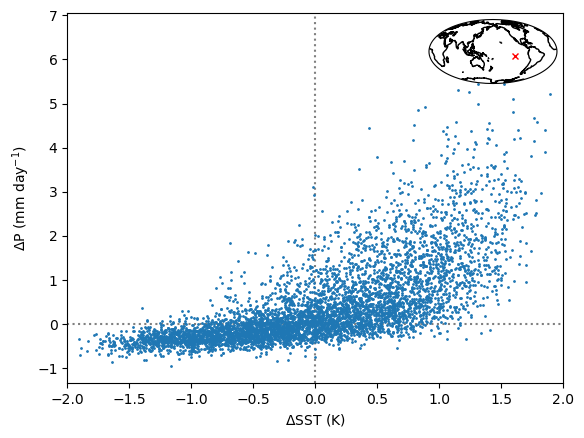

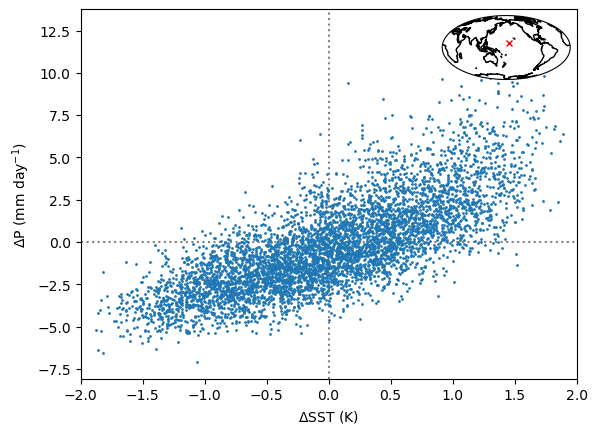

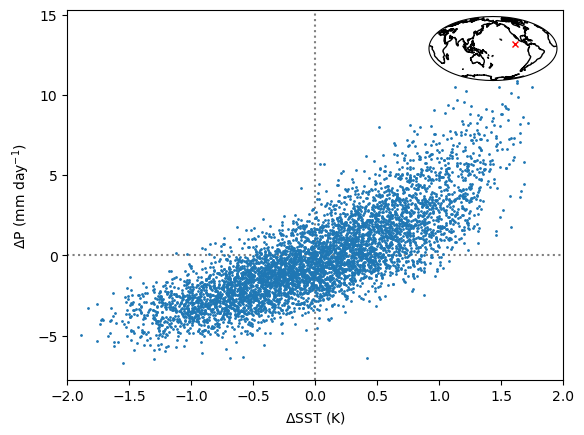

In [9]:
for lat in (-10, 10):
    for lon in pacific_lons[::30]:
        fig, ax, ax2 = plot_correlation(delta_precip, delta_SST, 
                                        sst_latitude=lat, sst_longitude=lon,
                                   precip_latitude=lat, precip_longitude=lon)

It appears that we can identify two linear regimes with different slopes. Sometimes the difference between slopes is more pronounced, while other times there is very little difference at all. This seems to be consistent with the idea that deep convection is triggered at a certain threshold temperature $T_c$, and that $T_c$ may or may not fall within the range of temperatures reached by $\Delta$SST.

We can try quantifying this difference by performing fitting a piecewise linear function with an arbitrary y-intercept. This will give different slopes on either side of 0K, and we can use the slope difference as a measure of the non-linearity of the correlation.

In [6]:
def piecewise_linear(x, y0, k1, k2):
    return np.piecewise(x, [x < 0], [lambda x:k1*x + y0, lambda x:k2*x + y0])

In [7]:
def piecewise_linear_origin(x, k1, k2):
    return np.piecewise(x, [x < 0], [lambda x:k1*x, lambda x:k2*x])

In [8]:
def piecewise_fit(delta_SST, delta_precip, 
                  sst_latitude, sst_longitude, 
                     precip_latitude, precip_longitude,
                 time_avg='ANNUAL'):
    '''
    Input:
    delta_SST (xarray dataarray)
    Output:
    y0 = y-intercept fit
    k1 = slope for delta_SST < 0K. (fit through arbitrary y0)
    k2 = slope for delta_SST > 0K. (fit through arbitrary y0)
    Difference between slopes provides crude estimate of degree of nonlinearity.
    Higher difference --> more nonlinear
    '''
    
    '''Calculate positive slope'''
    x = delta_SST.sel(lat=sst_latitude, lon=sst_longitude).values
    y = delta_precip.sel(time_avg=time_avg, 
                         lat=precip_latitude, 
                         lon=precip_longitude).values * np.cos(np.deg2rad(precip_latitude))
    p, e = optimize.curve_fit(piecewise_linear, x, y)
    y0, k1, k2 = p[0], p[1], p[2]
    return y0, k1, k2

In [9]:
def piecewise_fit_origin(delta_SST, delta_precip, 
                  sst_latitude, sst_longitude, 
                     precip_latitude, precip_longitude,
                 time_avg='ANNUAL'):
    '''
    Input:
    delta_SST (xarray dataarray)
    Output
    k1 = slope for delta_SST < 0K. 
    k2 = slope for delta_SST > 0K. 
    Difference between slopes provides crude estimate of degree of nonlinearity.
    Higher difference --> more nonlinear
    '''
    
    '''Calculate positive slope'''
    x = delta_SST.sel(lat=sst_latitude, lon=sst_longitude).values
    y = delta_precip.sel(time_avg=time_avg, 
                         lat=precip_latitude, 
                         lon=precip_longitude).values * np.cos(np.deg2rad(precip_latitude))
    p, e = optimize.curve_fit(piecewise_linear_origin, x, y)
    k1, k2 = p[0], p[1]
    return k1, k2

In [16]:
# example of a point
k1, k2 = piecewise_fit_origin(delta_SST, delta_precip, sst_latitude=-10, sst_longitude=243.75, 
                     precip_latitude=-10, precip_longitude=243.75)
print(k1, k2)

0.2637131508737466 1.4502756681138043


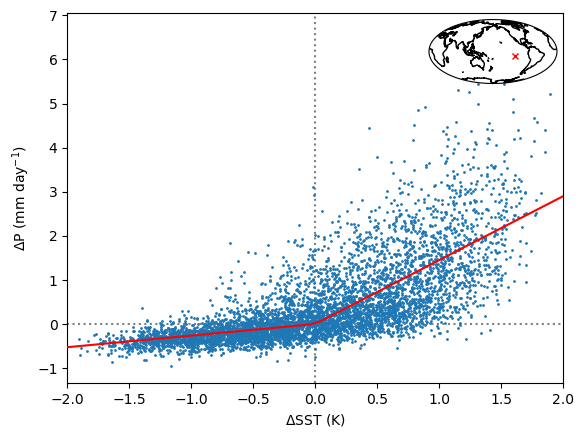

In [17]:
fig, ax, ax2 = plot_correlation(delta_precip, delta_SST, sst_latitude=-10, sst_longitude=243.75,
                                   precip_latitude=-10, precip_longitude=243.75)
ax.plot(np.linspace(-2, 2, num=50), piecewise_linear_origin(np.linspace(-2, 2, num=50), k1, k2), color='red', zorder=100)
plt.savefig('local_corr.pdf')
#plt.show()

We now perform this analysis for every grid point, and plot the difference in slopes on a contour map.

In [10]:
def visualise_slope_diffs(slope_diffs, vmin=0, vmax=6, levels=15,ticks=np.arange(-5, 5, 0.5)):
    
    lats = slope_diffs.lat.values
    lons = slope_diffs.lon.values
    
    fig, ax = map_with_latlon(central_longitude=150)
    fig.set_size_inches(20, 8)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='k', facecolor='white')
    #divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=(vmin+vmax)/2, vmax=vmax)

    slope_diffs_, lons_ = add_cyclic_point(slope_diffs, coord=lons)
    
    contourf = ax.contourf(lons_, lats, slope_diffs_,
                        transform=ccrs.PlateCarree(), levels=levels,
                              linewidths=1, zorder=1, cmap='RdBu_r')
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())
    #ax.set_title(r'Difference between slopes for $\Delta \mathrm{SST}>0\mathrm{K}$ and $\Delta \mathrm{SST}<0\mathrm{K}$ (local $\Delta \mathrm{P}$ vs. $\Delta \mathrm{SST}$ correlations)')
    cbar = fig.colorbar(contourf, location='bottom', ticks=ticks, pad=0.1)
    cbar.set_label(r'Difference in slopes ($\mathrm{mm} \ \mathrm{day}^{-1} \ \mathrm{K}^{-1}$) ')
    return fig, ax

In [11]:
def visualise_intercepts(intercepts, vmin=-4, vmax=1, levels=15):
    fig, ax = map_with_latlon(central_longitude=150)
    fig.set_size_inches(10, 5)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='k', facecolor='white')
    divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=(vmin+vmax)/2, vmax=vmax)

    intercepts_, lons_ = add_cyclic_point(intercepts, coord=lons)

    contourf = ax.contourf(lons_, lats, intercepts_,
                        transform=ccrs.PlateCarree(),
                        norm=divnorm, levels=15,
                              linewidths=1, zorder=1, cmap='bwr')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())
    ax.set_title(r'$\Delta \mathrm{Precip}$ intercept of piecewise linear function at $\Delta \mathrm{SST} = 0$')
    cbar = fig.colorbar(contourf, location='right', cax=cax)
    cbar.set_label(r'Intercept ($\mathrm{mm} \ \mathrm{day}^{-1}$) ')

    return fig, ax

In [20]:
filepath = os.path.join(os.getcwd(), "nonlinearity_data")
slope_diffs = xr.open_dataarray(os.path.join(filepath, "slope_diffs_local_fixed_origin.nc"))
intercepts = xr.open_dataarray(os.path.join(filepath, "intercepts_local.nc"))

In [43]:
for lat in lats:
    for lon in lons:
        if lat > 60 or lat < 60:
            continue
        k1, k2 = piecewise_fit_origin(delta_SST, delta_precip, sst_latitude=lat, sst_longitude=lon, 
                     precip_latitude=lat, precip_longitude=lon)
        slope_diffs.loc[lat, lon] = k2 - k1

NameError: name 'lats' is not defined

In [44]:
#slope_diffs.to_netcdf("nonlinearity_data/slope_diffs_local_fixed_origin.nc")

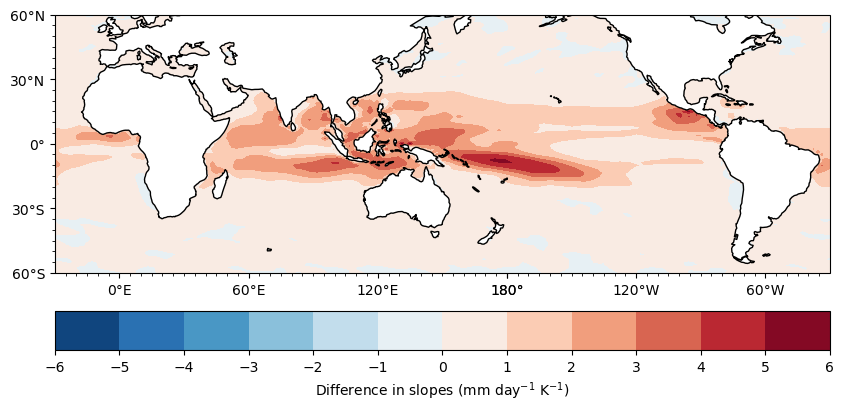

In [25]:
levels=np.linspace(-6, 6, num=13)
ticks=np.arange(-7, 7, 1)

fig, ax = visualise_slope_diffs(slope_diffs, 
                                vmax = np.amax(slope_diffs.values), 
                                vmin=np.amin(slope_diffs.values), 
                                levels=levels, ticks=ticks)
fig.set_size_inches(10, 5)
plt.savefig('slope_diffs_fixed_origin.pdf')

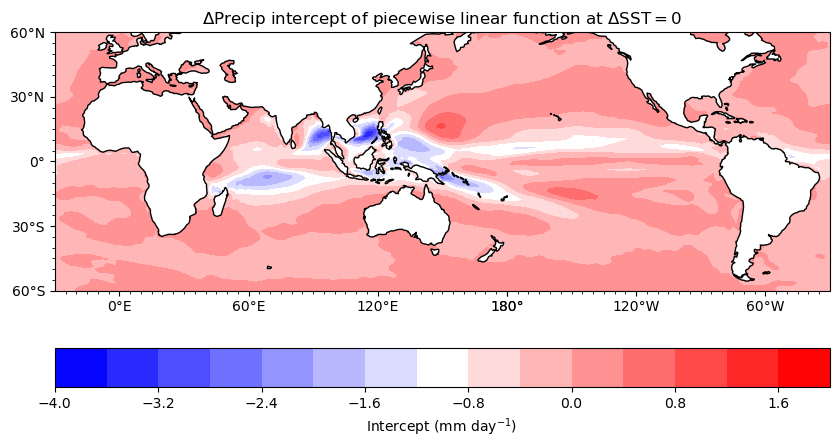

In [95]:
fig, ax = visualise_intercepts(intercepts, 
                                vmax = np.amax(intercepts.values), 
                                vmin = np.amin(intercepts.values), 
                                levels=10)
plt.show()

Let's choose a point with a particularly negative difference in slopes.

In [2]:
lat1 = 12.5
lon1 = 116.25

fig, ax, ax2 = plot_correlation(delta_precip, delta_SST, sst_latitude=lat1, sst_longitude=lon1,
                                   precip_latitude=lat1, precip_longitude=lon1)
y0, k1, k2 = piecewise_fit(delta_SST, delta_precip, sst_latitude=lat1, sst_longitude=lon1, 
                     precip_latitude=lat1, precip_longitude=lon1)
ax.plot(np.linspace(-2, 2, num=50), piecewise_linear(np.linspace(-2, 2, num=50), y0, k1, k2), color='red', zorder=100)

plt.show()

NameError: name 'delta_precip' is not defined

It is interesting that there is a significant, non-zero intercept. This could suggest significant non-local contributions to delta_precip at each gridpoint, which makes sense given what we know about the global teleconnection operator.

Let's check to make sure that the source of this non-zero intercept isn't correlations with delta_SSTs at gridpoints far away from the gridpoint in question. We can do this by plotting the correlation between delta_SST at this gridpoint (lat=12.5, lon=116.25) with delta_SST's at other gridpoints. We can similarly plot the correlation between delta_precip at this gridpoint vs. delta_precip at other gridpoints.

In [12]:
def calculate_sst_rvalues(mylat, mylon):
    sst_covariances = xr.DataArray(np.zeros((len(lats),len(lons))), coords=[lats, lons], dims=["lat", "lon"]).compute()
    delta_SST_point = delta_SST.sel(lat=mylat, lon=mylon).values
    for lat in lats:
        for lon in lons:
            sst_covariances.loc[dict(lat=lat, lon=lon)] = stats.spearmanr(delta_SST_point, delta_SST.sel(lat=lat, lon=lon).values)[0]
    covariances.to_netcdf("SST_rvalues_lat{}_lon{}.nc".format(mylat, mylon))

In [13]:
def calculate_precip_rvalues(mylat, mylon):
    precip_covariances = xr.DataArray(np.zeros((len(lats),len(lons))), coords=[lats, lons], dims=["lat", "lon"]).compute()
    delta_precip_vector = point_delta_precip_vector(delta_precip, mylat=mylat, mylon=mylon)
    for lat in lats:
        for lon in lons:
            precip_covariances.loc[dict(lat=lat, lon=lon)] = stats.spearmanr(delta_precip_vector, point_delta_precip_vector(delta_precip, mylat=lat, mylon=lon))[0]
    lat_filename = str(mylat).replace(".","")
    lon_filename = str(mylon).replace(".","")
    precip_covariances.to_netcdf("precip_rvalues_lat{}_lon{}.nc".format(lat_filename, lon_filename))
    print('Lat{} Lon{} completed'.format(mylat, mylon))

In [18]:
mylats = [-10, -20]
mylons = pacific_lons[::5]

for mylat in mylats:
    for mylon in mylons:
        calculate_precip_rvalues(mylat, mylon)

Lat-10 Lon187.5 completed
Lat-10 Lon196.875 completed
Lat-10 Lon206.25 completed
Lat-10 Lon215.625 completed
Lat-10 Lon225.0 completed
Lat-10 Lon234.375 completed
Lat-10 Lon243.75 completed
Lat-10 Lon253.125 completed
Lat-10 Lon262.5 completed


KeyboardInterrupt: 

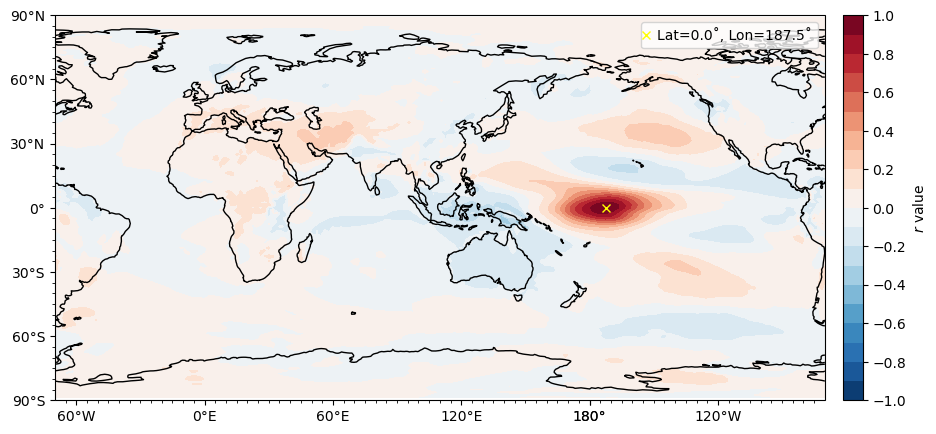

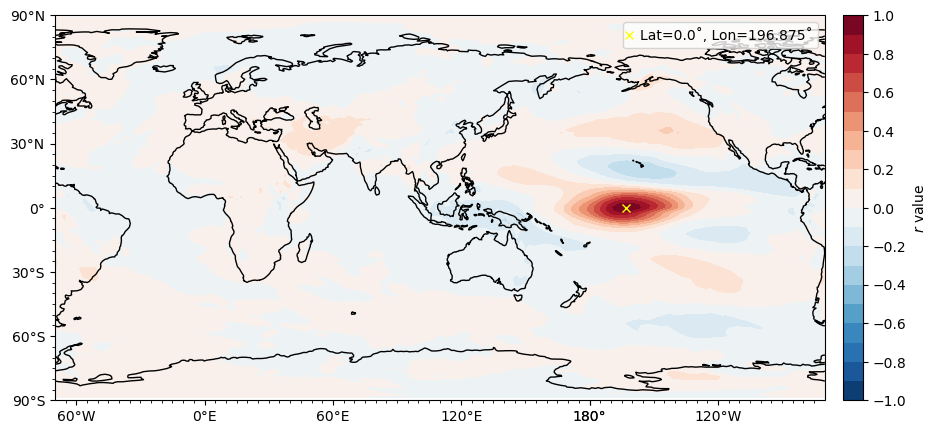

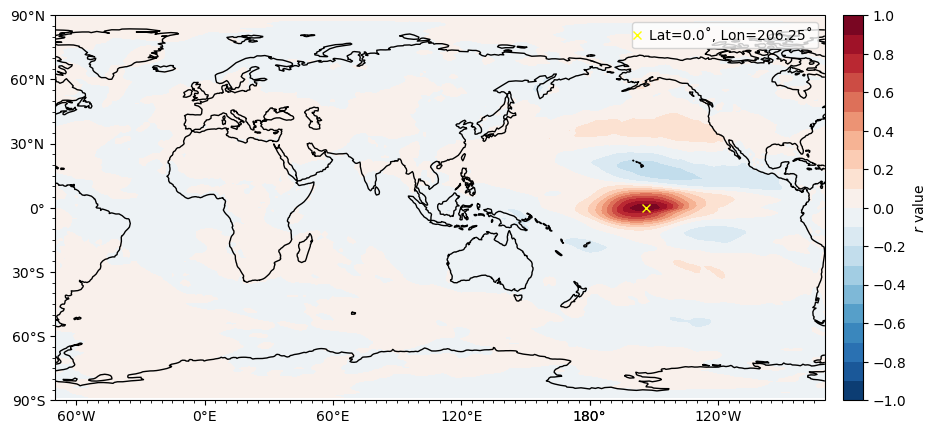

In [43]:
for longitude in (187.5, 196.875, 206.25):
    filename = str(longitude).replace(".","")
    covariances = xr.open_dataset("correlation_data/precip_rvalues_lat0_lon{}.nc".format(filename))['__xarray_dataarray_variable__']
    fig, ax = map_with_latlon(central_longitude=110)
    fig.set_size_inches(12, 5)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    covariances_, lons_ = add_cyclic_point(covariances, coord=lons)
    levels = np.linspace(-1, 1, num=21)
    contourf = ax.contourf(lons_, lats, covariances_,
                            transform=ccrs.PlateCarree(),
                                  linewidths=1, zorder=1, cmap='RdBu_r',
                          norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), levels=levels)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    #ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k', facecolor='white')
    ax.coastlines()
    ax.plot(longitude, 0, marker='x', color='yellow', 
            zorder=100,transform=ccrs.PlateCarree(), linewidth=1,
           label='Lat=0.0˚, Lon={}˚'.format(longitude))
    ax.legend(handlelength=0)
    cbar = fig.colorbar(contourf,
                          ticks = np.arange(-1, 1.1, 0.2), location='right', pad=0.02)
    cbar.set_label('$r$ value')
    plt.savefig('precip_correlations_lat0_lon{}.pdf'.format(longitude))

So we can rule out correlations with far away delta_SST gridpoints as the cause of the non-zero intercept. However for delta_precip we see that there are non-local correlations, and this may give rise to the intercept we observe.

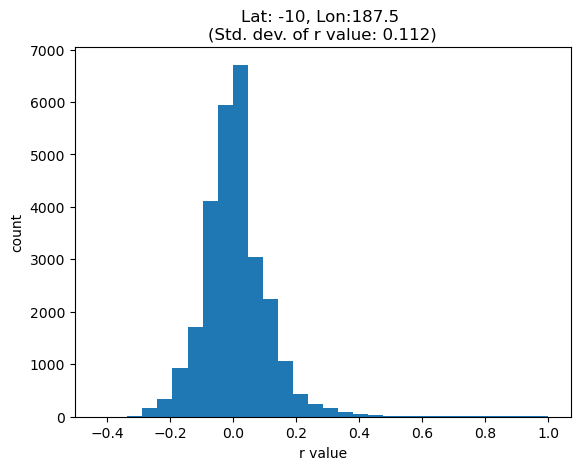

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(0.11225727)

In [51]:
rvalues = xr.open_dataset("correlation_data/precip_rvalues_lat-10_lon1875.nc")['__xarray_dataarray_variable__']
rvalues.plot.hist(bins=30)
plt.xlabel('r value')
plt.ylabel('count')
std = np.round_(rvalues.std().values, 3)
plt.title('Lat: -10, Lon:187.5 \n(Std. dev. of r value: {})'.format(std))
plt.show()
rvalues.std()

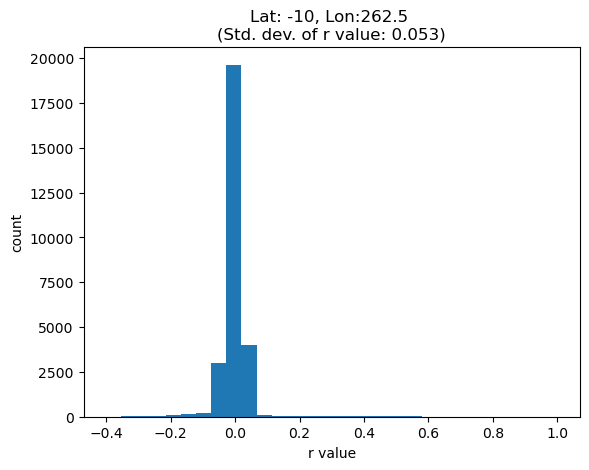

In [53]:
rvalues = xr.open_dataset("correlation_data/precip_rvalues_lat-10_lon2625.nc")['__xarray_dataarray_variable__']
rvalues.plot.hist(bins=30)
plt.xlabel('r value')
plt.ylabel('count')
std = np.round_(rvalues.std().values, 3)
plt.title('Lat: -10, Lon:262.5 \n(Std. dev. of r value: {})'.format(std))
plt.show()

### Case study: delta_precip point in the Mediterranean

Pick a random point in the Mediterranean, say Lat = 40, Lon = 9.375, for delta_precip.

First compute the GTO for this point, so we can figure out which are regions of high sensitivity.

In [16]:
delta_precip_vector = point_delta_precip_vector(delta_precip, mylat=med_lat,
                                                mylon=med_lon, time_avg='ANNUAL')
calculate_GTO(delta_SST, delta_precip_vector, verbose=True,
                 lat_range = [-60, 60], lon_range =[0, 360], sig_test=True)

Latitude 60.0 completed
Latitude 50.0 completed
Latitude 40.0 completed
Latitude 30.0 completed
Latitude 20.0 completed
Latitude 10.0 completed
Latitude 0.0 completed
Latitude -10.0 completed
Latitude -20.0 completed
Latitude -30.0 completed
Latitude -40.0 completed
Latitude -50.0 completed
Latitude -60.0 completed


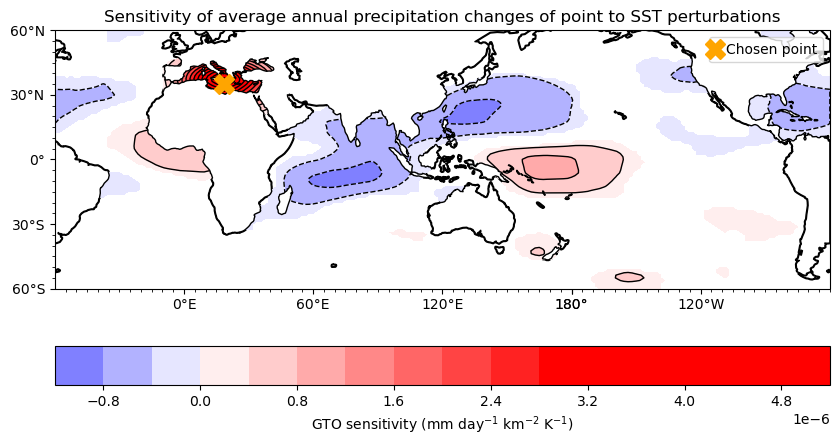

In [17]:
G_point = xr.open_dataset("GTO_lat35_lon1875.nc")['__xarray_dataarray_variable__'] # select data array of G val
fig, ax = visualise_GTO(G_point, central_longitude=120, levels=15, vmax=3e-6, vmin=-2e-6)
plt.title('Sensitivity of average annual precipitation changes of point to SST perturbations')

ax.plot(med_lon, med_lat,  markersize=15, marker='X', color='orange', 
        zorder=100,transform=ccrs.PlateCarree(), linewidth=1,
       label='Chosen point')
ax.legend(handlelength=0)
plt.show()

Now compute the slope differences (and the intercepts). Do the regions of non-linearity correspond with the regions of high GTO sensitivity?

In [47]:
slope_diffs = xr.DataArray(np.zeros((len(lats),len(lons))), coords=[lats, lons], dims=["lat", "lon"]).compute()
intercepts = xr.DataArray(np.zeros((len(lats),len(lons))), coords=[lats, lons], dims=["lat", "lon"]).compute()

In [58]:
precip_latitude=40
precip_longitude=9.375

for lat in lats:
    if lat < -60 or lat > 60:
        continue
    if (lat % 10) == 0:
        print('Calculating latitude {}'.format(lat))
    for lon in lons:
        y0, k1, k2 = piecewise_fit(delta_SST, delta_precip, 
                                   sst_latitude=lat, sst_longitude=lon, 
                                   precip_latitude=precip_latitude, 
                                   precip_longitude=precip_longitude)
        diff = k2 - k1
        slope_diffs.loc[dict(lat=lat, lon=lon)] = diff
        intercepts.loc[dict(lat=lat, lon=lon)] = y0

slope_diffs.to_netcdf("slope_diffs_Lat{}Lon{}.nc".format(precip_latitude, precip_longitude))
intercepts.to_netcdf("intercepts_Lat{}Lon{}.nc".format(precip_latitude, precip_longitude))

Calculating latitude 60.0
Calculating latitude 50.0
Calculating latitude 40.0
Calculating latitude 30.0
Calculating latitude 20.0
Calculating latitude 10.0
Calculating latitude 0.0
Calculating latitude -10.0
Calculating latitude -20.0
Calculating latitude -30.0
Calculating latitude -40.0
Calculating latitude -50.0
Calculating latitude -60.0
